In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [5]:
img=cv2.cvtColor(cv2.imread("dtimg.png"),cv2.COLOR_BGR2RGB)

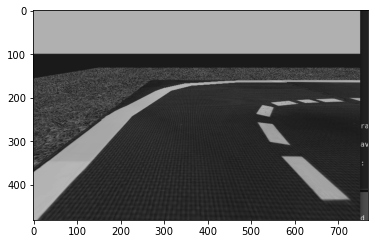

In [29]:
plt.imshow(img[:,:,0],cmap='gray')

In [30]:
stencil = np.zeros_like(img[:,:,0])

# specify coordinates of the polygon
polygon = np.array([[0,500], [0,300], [800,200], [800,500]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

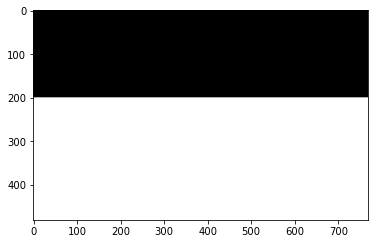

In [33]:
# plt.figure(figsize=(10,10))
plt.imshow(stencil,cmap='gray')
plt.show()

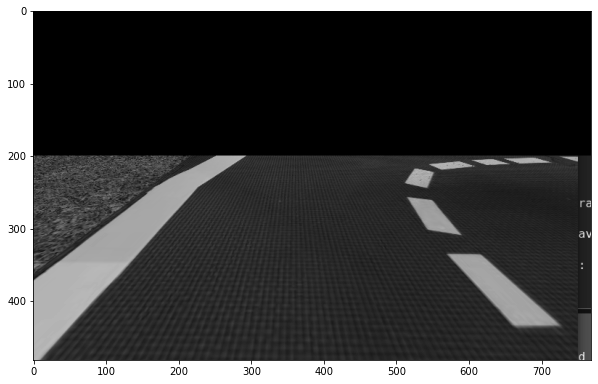

In [35]:
img2 = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img2, cmap= "gray")
plt.show()

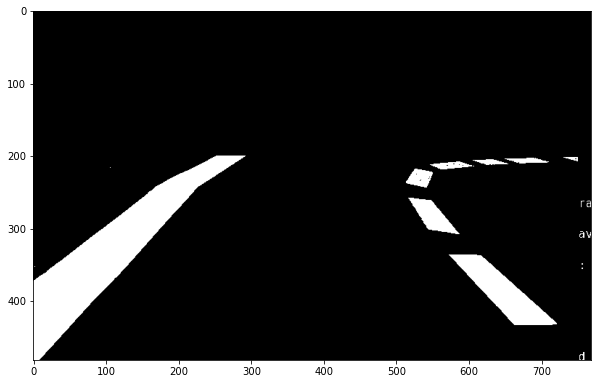

In [36]:
# apply image thresholding
ret, thresh = cv2.threshold(img2, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

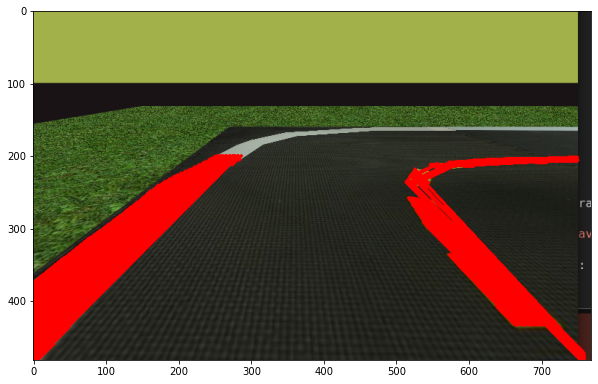

In [38]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = img.copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

In [39]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

In [41]:
import logging
def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]
lane_lines=average_slope_intercept(img.copy(),lines)

In [42]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

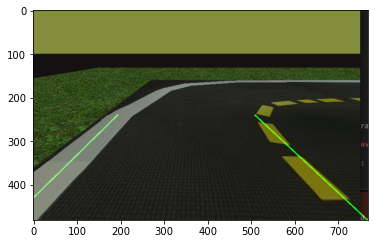

In [43]:
imgnew=display_lines(img.copy(),lane_lines)
plt.imshow(imgnew)

In [44]:
def compute_steering_angle(frame, lane_lines):
    """ Find the steering angle based on lane line coordinate
        We assume that camera is calibrated to point to dead center
    """
    if len(lane_lines) == 0:
        logging.info('No lane lines detected, do nothing')
        return -90

    height, width, _ = frame.shape
    if len(lane_lines) == 1:
        logging.debug('Only detected one lane line, just follow it. %s' % lane_lines[0])
        x1, _, x2, _ = lane_lines[0][0]
        x_offset = x2 - x1
    else:
        _, _, left_x2, _ = lane_lines[0][0]
        _, _, right_x2, _ = lane_lines[1][0]
        camera_mid_offset_percent = 0.02 # 0.0 means car pointing to center, -0.03: car is centered to left, +0.03 means car pointing to right
        mid = int(width / 2 * (1 + camera_mid_offset_percent))
        x_offset = (left_x2 + right_x2) / 2 - mid

    # find the steering angle, which is angle between navigation direction to end of center line
    y_offset = int(height / 2)

    angle_to_mid_radian = math.atan(x_offset / y_offset)  # angle (in radian) to center vertical line
    angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
    steering_angle = angle_to_mid_deg + 90  # this is the steering angle needed by picar front wheel

    logging.debug('new steering angle: %s' % steering_angle)
    return steering_angle

In [46]:
import math
compute_steering_angle(img.copy(),lane_lines)

81

In [47]:
def display_heading_line(frame, steering_angle, line_color=(0, 0, 255), line_width=5, ):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right 
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image

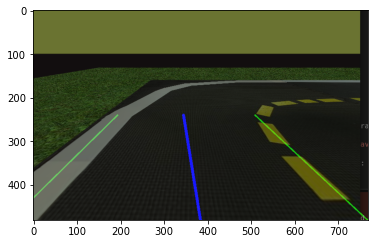

In [50]:
plt.imshow(display_heading_line(imgnew,81))